**Tuberculosis Binary Classification** using **VGG-19** pretrained model

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# main dependencies needed
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
Base_data = '/content/drive/MyDrive/TUBERCULOSIS'


**Preprocessing Data**

In [4]:
# Preprocessing
import cv2
import os
import imghdr
data = tf.keras.utils.image_dataset_from_directory(Base_data, image_size=(224,224))
data_dir = Base_data 
image_exts = ['png', 'jpeg']
image_size = (224, 224)

for image_class in os.listdir(data_dir): 
    for image_name in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image_name)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            #if tip not in image_exts or 'mask' in image_name: 

            if tip not in image_exts: 
                # print('Image not in ext list or has mask in its name: {}'.format(image_path))
                os.remove(image_path)
            else:
                img = cv2.resize(img, image_size)
                cv2.imwrite(image_path, img)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))


Found 1400 files belonging to 2 classes.


In [8]:
# Display the name of classes and their corresponding number of files.
number_of_images = {}
for dir in os.listdir(Base_data):
  number_of_images[dir] = len(os.listdir(os.path.join(Base_data, dir)))

number_of_images.items()

dict_items([('Tuberculosis', 700), ('Normal', 700)])

In [9]:
# Encoding the classes
unique_classes = []
for path in os.listdir(Base_data):
    unique_classes.append(path)
print(unique_classes)
class_index = [unique_classes[1], unique_classes[0]]
label_encoder = LabelEncoder()

# Fit the encoder to the unique classes and transform the class_index
encoded_classes = label_encoder.fit_transform(class_index)

# Print the encoded classes with their respective index values
for c, e in zip(class_index, encoded_classes):
    print(c, "-", e)

['Tuberculosis', 'Normal']
Normal - 0
Tuberculosis - 1


In [10]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

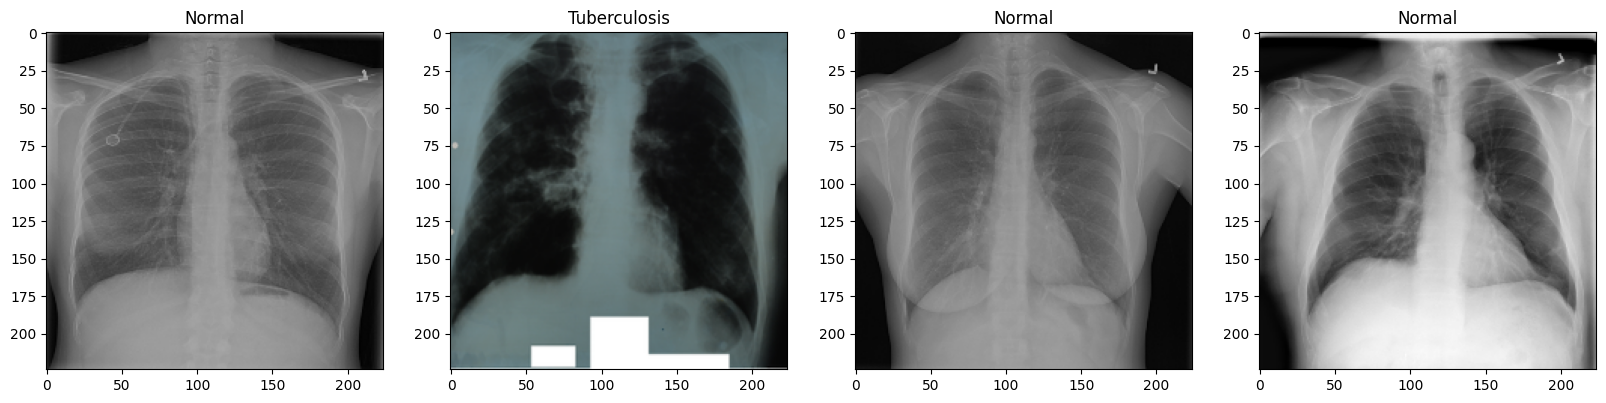

In [11]:
# Display some examples - 0 is benign and 1 is malignant
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    if batch[1][idx] == 0:
        ax[idx].title.set_text('Normal')
    else:
        ax[idx].title.set_text('Tuberculosis')

In [12]:
# Scale the data 
# We standardize the pixels to range 0-1

data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()

(array([[[[0.28235295, 0.29803923, 0.34117648],
          [0.65882355, 0.7137255 , 0.78039217],
          [0.7607843 , 0.80784315, 0.83137256],
          ...,
          [0.827451  , 0.85882354, 0.87058824],
          [0.827451  , 0.85882354, 0.87058824],
          [0.8235294 , 0.85490197, 0.8666667 ]],
 
         [[0.29803923, 0.3137255 , 0.36078432],
          [0.67058825, 0.7254902 , 0.7921569 ],
          [0.7607843 , 0.80784315, 0.83137256],
          ...,
          [0.8392157 , 0.85882354, 0.8745098 ],
          [0.8352941 , 0.85490197, 0.87058824],
          [0.827451  , 0.85490197, 0.87058824]],
 
         [[0.30588236, 0.3254902 , 0.3764706 ],
          [0.68235296, 0.7411765 , 0.8039216 ],
          [0.7607843 , 0.8117647 , 0.83137256],
          ...,
          [0.8392157 , 0.85882354, 0.8745098 ],
          [0.8352941 , 0.85882354, 0.8745098 ],
          [0.83137256, 0.85882354, 0.87058824]],
 
         ...,
 
         [[0.13333334, 0.13333334, 0.08235294],
          [0.12549

In [13]:
# Split the data 
train_size = int(len(data)*.7)
# Used During Training
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)


In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Build, Train, using vgg19

In [15]:
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

# Load the VGG19 model without the top layers (include_top=False)
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the VGG19 model layers weights
for layer in vgg_model.layers:
    layer.trainable = False

# Creating a new model a new model using the VGG19 model as a base
model = Sequential()
model.add(vgg_model)


# Adding  a new classifier layer on top of the base model
model.add(Flatten())
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


In [16]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 224)               5619936   
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 225       
                                                                 
Total params: 25,644,545
Trainable params: 5,620,161
Non-trainable params: 20,024,384
_________________________________________________________________


***model compilation***

In [17]:
# Compile the model with the desired optimizer and loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


***model training***

In [18]:

# Train the model using the data
history = model.fit(train, epochs=5, batch_size=32,validation_data=val)

Epoch 1/5
30/30 [==============================] - 881s 29s/step - loss: 1.4588 - accuracy: 0.6969 - val_loss: 0.1780 - val_accuracy: 0.9219
Epoch 2/5
30/30 [==============================] - 868s 29s/step - loss: 0.1564 - accuracy: 0.9500 - val_loss: 0.1319 - val_accuracy: 0.9531
Epoch 3/5
30/30 [==============================] - 869s 29s/step - loss: 0.1120 - accuracy: 0.9677 - val_loss: 0.0920 - val_accuracy: 0.9727
Epoch 4/5
30/30 [==============================] - 869s 29s/step - loss: 0.0815 - accuracy: 0.9844 - val_loss: 0.0725 - val_accuracy: 0.9805
Epoch 5/5
30/30 [==============================] - 868s 29s/step - loss: 0.0743 - accuracy: 0.9792 - val_loss: 0.0706 - val_accuracy: 0.9805


**Performance Graphs**

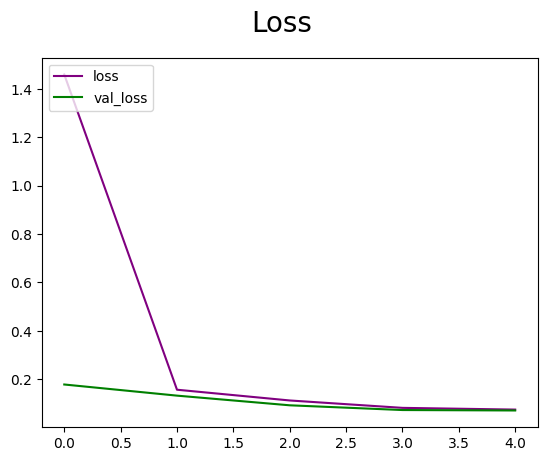

In [19]:
# Plot Loss Graph
fig = plt.figure()
plt.plot(history.history['loss'], color='purple', label='loss')
plt.plot(history.history['val_loss'], color='green', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

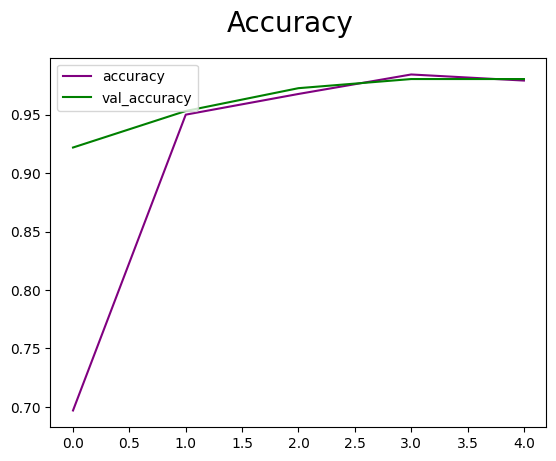

In [20]:
# Plot Accuracy Graph
fig = plt.figure()
plt.plot(history.history['accuracy'], color='purple', label='accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**Performance Evaluation**

In [24]:
# Model Perfomance
import pandas as pd
X = []
y = []

# Load the test data
for batch in test.as_numpy_iterator():
    A, b = batch
    X.append(A)
    y.append(b)

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# Predict on the entire test data
yhat = model.predict(X)


4/4 [==============================] - 94s 24s/step


In [25]:
# Test one of the batches

y = y.reshape((-1,))
yhat = yhat.reshape((-1,))
yhat = yhat.round()
dfNew = pd.DataFrame(data={"Actual Value": y, "Predicted Value": yhat})

pd.set_option('display.max_rows', None)
dfNew

,Actual Value,Predicted Value
0,1,1.0
1,1,1.0
2,0,0.0
3,1,1.0
4,1,1.0
5,0,0.0
6,1,1.0
7,0,0.0
8,0,0.0
9,0,0.0


**Classification Report**

In [26]:
from sklearn.metrics import classification_report, confusion_matrix 
report = classification_report(y, yhat, target_names=['Normal', 'Tuberculosis'], digits=4)
print(report)

              precision    recall  f1-score   support

      Normal     0.9500    1.0000    0.9744        57
Tuberculosis     1.0000    0.9577    0.9784        71

    accuracy                         0.9766       128
   macro avg     0.9750    0.9789    0.9764       128
weighted avg     0.9777    0.9766    0.9766       128



**Confusion Matrix**

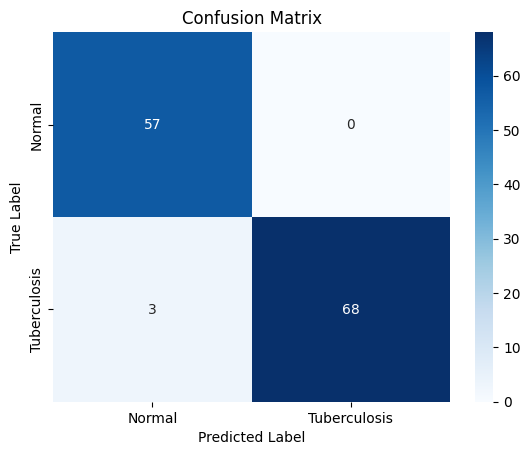

In [27]:
# Define class labels
import seaborn as sns
# Compute confusion matrix 
cm = confusion_matrix(y, np.round(yhat))
class_names = ['Normal', 'Tuberculosis']

# Plot heatmap of confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Testing on some images**

***Normal Image with no TB***

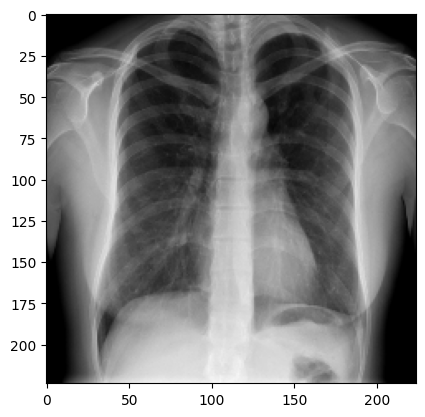

In [28]:
img = cv2.imread('/content/drive/MyDrive/Hackfest_Images/TUBERCULOSIS/Normal-4.png')
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [29]:
Img_pred = model.predict(np.expand_dims(resize/255, 0))
Img_pred.item()

1/1 [==============================] - 1s 809ms/step


0.04815702512860298

In [30]:
# classify the possible class of the image
def classifyImage(Img_pred):
  if Img_pred > 0.5: 
      print('You have TUBERCULOSIS')
  else:
      print('You are NORMAL(no tb)')
  
classifyImage(Img_pred)

You are NORMAL(no tb)


***X-ray Image with TB***

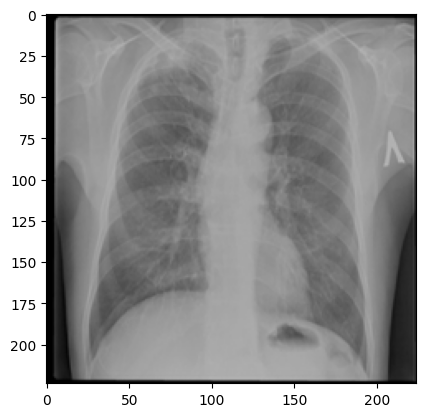

In [31]:
img = cv2.imread('/content/drive/MyDrive/Hackfest_Images/TUBERCULOSIS/Tuberculosis-5.png')
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [32]:
Img_pred = model.predict(np.expand_dims(resize/255, 0))
Img_pred.item()

1/1 [==============================] - 1s 625ms/step


0.9773682951927185

In [33]:
# Classify image
classifyImage(Img_pred)

You have TUBERCULOSIS


In [34]:
from keras.models import load_model
model.save('/content/drive/MyDrive/Hackfest_AIModels/tuberculosisClassifier.h5')